# CSC2541 - Lab 1: Deep Learning for structure-based drug design (SBDD)

Structure-based drug design (SBDD) aims at designing small-molecule ligands that bind with high affinity and specificity to pre-determined protein targets which have been identified as having therapeutic potential. Specifically, this approach focuses on leveraging the 3D structure of the protein target to rationally design a ligand.

In this lab, we aim at giving you an introduction to SBDD and the latest deep learning models used in the field. The lab is structured into three parts

### Table of Content

1.   Pre-module: Introduction to the Protein Data Bank (PDB) (~30 mins)
2.   Module: Exploring how ML does at Ligand pose prediction (~50 mins)
3.   Post-module (assignment): Evaluating a state of the art ML model (Boltz2) on various protein ligand complex pose prediction (~60 mins)

# Colab Set Up

In [8]:
# Installing packaging necessary to run the notebook

from IPython.utils import io

! pip install -q condacolab
import condacolab
condacolab.install()

✨🍰✨ Everything looks OK!


In [9]:
setup_repo="https://github.com/rajaonsonella/csc2541_lab1"
!git clone {setup_repo}

fatal: destination path 'csc2541_lab1' already exists and is not an empty directory.


In [11]:
!conda config --show-sources

In [12]:
# Run setup script
!chmod +x csc2541_lab1/setup.sh
!bash csc2541_lab1/setup.sh


[INFO] Step 1: Installing Python packages using Conda and Pip...

/usr/local/lib/python3.12/site-packages/conda/base/context.py:211: FutureWarning: Adding 'defaults' to channel list implicitly is deprecated and will be removed in 25.9. 

To remove this warning, please choose a default channel explicitly with conda's regular configuration system, e.g. by adding 'defaults' to the list of channels:

  conda config --add channels defaults

For more information see https://docs.conda.io/projects/conda/en/stable/user-guide/configuration/use-condarc.html

  deprecated.topic(
Channels:
 - conda-forge
 - defaults
Platform: linux-64

SpecsConfigurationConflictError: Requested specs conflict with configured specs.
  requested specs: 
    - autogrid
    - cctbx-base==2024.6
    - gemmi
    - meeko==0.6.1
    - numpy
    - pip
    - python=3.11
    - rdkit
    - scipy
    - vina
  pinned specs: 
    - cuda-version=12
    - python=3.12
    - python_abi=3.12[build=*cp312*]
Use 'conda config --show-s

In [6]:
import ipywidgets
from IPython.display import display

# Pre-module: Introduction to the Protein Data Bank (PDB)

The Protein Data Bank (PDB) is a **global repository of 3D structural data for biological macromolecules** like proteins, DNA, RNA, and their complexes with ligands or drugs.


It stores experimentally determined structures obtained through techniques such as X-ray crystallography, nuclear magnetic resonance (NMR) spectroscopy, and cryo-electron microscopy (cryo-EM). Each entry in the PDB contains atomic coordinates, experimental details, and annotations describing function and interactions of the macromolecule.

Learn more about the history of PDB [here](https://www.rcsb.org/pages/about-us/history) and check out the overall growth of the database [here](https://www.rcsb.org/stats/growth/growth-released-structures)!

**In this pre-module we are going to:**

* Review the basics about proteins
* Learn more about the file format used to store this type of data
* Learn how to programmatically retrieve protein structures and extract key metadata
* Visualize protein structures interactively in 3D using Python tools

## Protein 101 recap

TBD

## The PDBx/mmCIF file format

The files found in the PDB are available in several formats (PDB, mmCIF, XML). We will focus on the PDBx/mmCIF file format, which is the current preferred format.


**Note:** This is a quick intro to the file format, full documentation can be found at [https://mmcif.wwpdb.org/](https://mmcif.wwpdb.org/)


Let's first download a file and open it to see what the format looks like:

In [8]:
# Download an mmCIF file

# Colab tip -- You can download the file to your local machine by:
# 1) clicking on the folder icon on the colab menu
# 2) locating the file and double-clicking on it

# Let's specify the PDB ID of the file we want to download
pdb_id = "4INS"

import urllib.request
urllib.request.urlretrieve(f"https://files.rcsb.org/download/{pdb_id}.cif", f"{pdb_id}.cif")

# View first few lines
num_lines_to_print = 10
with open("4INS.cif") as f:
    print(f"Printing the first {num_lines_to_print} lines in the file: \n")
    for _ in range(num_lines_to_print):
        print(f.readline().strip())

Printing the first 10 lines in the file: 

data_4INS
#
_entry.id   4INS
#
_audit_conform.dict_name       mmcif_pdbx.dic
_audit_conform.dict_version    5.397
_audit_conform.dict_location   http://mmcif.pdb.org/dictionaries/ascii/mmcif_pdbx.dic
#
loop_
_database_2.database_id


As you can see, it is quite challenging to handle these files "by ourselves" that's why many python libraries have built-in parsers to easily retrieve this data and focus on the rest. The lines we are usually interested in within this file are the one describing the 3D structure of the protein, let's use of of those python packages to extract this information from this file more easily.

In [28]:
from biopandas.mmcif import PandasMmcif

# Read the mmCIF file
mmcif = PandasMmcif().read_mmcif(f'{pdb_id}.cif')

# Display the different "keys" of the returned dictionnary
print(mmcif.df.keys())

dict_keys(['ATOM', 'HETATM', 'ANISOU'])


We created a dictionary ```mmcif``` which contains 3 keys:

* **ATOM** records represent atoms that belong to standard polymer chains such as proteins and nucleic acids.

* **HETATM** records describe atoms from non-polymer molecules like ligands, metal ions (e.g., zinc), and solvent molecules (e.g., water).

* **ANISOU** records contain detailed information on atomic vibrations (anisotropic displacement parameters) derived from crystallography, which provide insight into atomic motion but are optional for most analyses.
Understanding these distinctions helps when filtering or visualizing structural components relevant to your study.

In [30]:
mmcif.df["ATOM"]

,group_PDB,id,type_symbol,label_atom_id,label_alt_id,label_comp_id,label_asym_id,label_entity_id,label_seq_id,pdbx_PDB_ins_code,...,Cartn_y,Cartn_z,occupancy,B_iso_or_equiv,pdbx_formal_charge,auth_seq_id,auth_comp_id,auth_asym_id,auth_atom_id,pdbx_PDB_model_num
0,ATOM,1,N,N,None,GLY,A,1,1,None,...,16.944,14.289,1.0,21.88,None,1,GLY,A,N,1
1,ATOM,2,C,CA,None,GLY,A,1,1,None,...,17.026,13.244,1.0,22.85,None,1,GLY,A,CA,1
2,ATOM,3,C,C,None,GLY,A,1,1,None,...,15.625,12.618,1.0,43.92,None,1,GLY,A,C,1
3,ATOM,4,O,O,None,GLY,A,1,1,None,...,14.728,13.407,1.0,25.22,None,1,GLY,A,O,1
4,ATOM,5,N,N,None,ILE,A,1,2,None,...,15.531,11.332,1.0,26.28,None,2,ILE,A,N,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
825,ATOM,826,C,CA,None,ALA,D,2,30,None,...,21.709,-11.876,1.0,15.58,None,30,ALA,D,CA,1
826,ATOM,827,C,C,None,ALA,D,2,30,None,...,21.534,-12.910,1.0,35.26,None,30,ALA,D,C,1
827,ATOM,828,O,O,None,ALA,D,2,30,None,...,20.451,-13.025,1.0,37.09,None,30,ALA,D,O,1
828,ATOM,829,C,CB,None,ALA,D,2,30,None,...,21.978,-10.527,1.0,32.86,None,30,ALA,D,CB,1


In [32]:
mmcif.df["HETATM"]

,group_PDB,id,type_symbol,label_atom_id,label_alt_id,label_comp_id,label_asym_id,label_entity_id,label_seq_id,pdbx_PDB_ins_code,...,Cartn_y,Cartn_z,occupancy,B_iso_or_equiv,pdbx_formal_charge,auth_seq_id,auth_comp_id,auth_asym_id,auth_atom_id,pdbx_PDB_model_num
830,HETATM,831,ZN,ZN,None,ZN,E,3,None,None,...,-0.004,7.891,0.33,10.40,None,101,ZN,B,ZN,1
831,HETATM,832,ZN,ZN,None,ZN,F,3,None,None,...,0.000,-8.039,0.33,11.00,None,101,ZN,D,ZN,1
832,HETATM,833,O,O,None,HOH,G,4,None,None,...,22.800,0.340,1.00,86.30,None,101,HOH,A,O,1
833,HETATM,834,O,O,None,HOH,G,4,None,None,...,20.399,0.771,1.00,76.27,None,102,HOH,A,O,1
834,HETATM,835,O,O,None,HOH,G,4,None,None,...,23.328,2.558,0.50,53.25,None,103,HOH,A,O,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1177,HETATM,1178,O,O,None,HOH,J,4,None,None,...,2.379,31.639,1.00,81.34,None,459,HOH,D,O,1
1178,HETATM,1179,O,O,None,HOH,J,4,None,None,...,21.561,31.604,1.00,55.36,None,460,HOH,D,O,1
1179,HETATM,1180,O,O,None,HOH,J,4,None,None,...,25.048,-12.333,1.00,77.73,None,461,HOH,D,O,1
1180,HETATM,1181,O,O,None,HOH,J,4,None,None,...,22.753,33.200,1.00,96.30,None,462,HOH,D,O,1


Spend some time exploring the tabular data visualization of this protein, and start imagining having to deal with several thousand of these files!

**Quiz:**

* Are there any solvent molecules present in that structure?
* How many amino acid is there in this protein? How about the number of heavy atoms? How about the number of chains?
* What does the "occupancy" column means? Why is this important?



Now, this is much more readable than the raw cif format, but it is not necessarily easy to get a feel of 3D data by looking at a table. Let's try adding some visualization to truly get a sense of what we are dealing with

## Visualizing proteins with py3Dmol



To do so, let's use the py3Dmol package created by the Koes group [see paper](https://doi.org/10.1093/bioinformatics/btu829)

In [61]:
import py3Dmol
view = py3Dmol.view(query=f'pdb:{pdb_id}')

# Set the style, we have to add separate visualizations for the hetero atoms
view.setStyle({'cartoon':{'color':'spectrum'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'grey', 'radius': 1.5}})
view.addStyle({'resn': 'HOH'}, {'sphere': {'color': 'red', 'radius': 0.5}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Let's exclude the water molecules from our visualization from now on. It's important to know they are here due to the experimental nature of the structure, but it hinders our visualization. On top of that, let's add a few small changes to how we're doing the rendering to see more.

In [62]:
view = py3Dmol.view(query=f'pdb:{pdb_id}')
view.setStyle({'cartoon': {'color':'spectrum'}})
view.addStyle({'atom': 'ZN'}, {'sphere': {'color': 'grey', 'radius': 1.5}})
view.addSurface(py3Dmol.VDW,{'opacity':0.7,'color':'white'}, {'not': {'resn': 'HOH'}})
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

**Quiz:**

* What does having solvent molecules within the crystal imply when modeling protein-ligand interactions?
* Another interesting thing about this protein structure is the 2 Zn ions it has. Can AlphaFold2 handle that type of atoms? If not, what are the potential consequences of this missing feature?

# Module: Predicting protein-ligand interactions

Now that we have seen how 3D protein-ligand data is usually stored and visualized, we can start thinking about how to exploit such data to discover new drugs *rationally*.

By this, we mean that instead of relying on purely trial-and-error methods in drug discovery, we can now **retrospectively** understand why this drug "works" by looking at how it complexes with a targeted protein, provided we have the experimental data. Even more exciting, if we understand how/why a certain ligand binds to a target protein, we can **prospectively** try to find new candidates using that knowledge.

The issues are that:
1. Obtaining this type of structural data is extremely hard
2. There are more drug-like molecules than starts in the universe

Therefore, we want to limit using experimental techniques and offload as much work as possible to computational techniques instead. Still, we are limited in how much compute we want to allocate to this *in silico* exploration. The usual rule of thumb is that the more precise a computational method is, the more it costs in computational time.

For the rest of this module, we are going to focus on 2 methods that are **computationally cheap** and used to predict how a ligand binds to a protein.




## Molecular Docking

The first method we are going to see is molecular docking. You can find a great review of the method [here](https://doi.org/10.1146/annurev-biochem-030222-120000) if you are interested in reading more about it.

Molecular docking frames the concept of protein ligand binding as a **prediction task**: Given the structure of the target protein and a compound of interest (the query molecule), predict a binding pose and its associated binding energy.

In short, we input:
* The 3D structure of the protein
* The ligand structure (either as a SMILES, or an initial 3D conformation)

and we obtain:
* The predicted 3D conformation

Most of the time, we need to provide an approximate guess of where the ligand will bind (a binding site). When the binding site is not specified, we refer to it as *blind docking*.





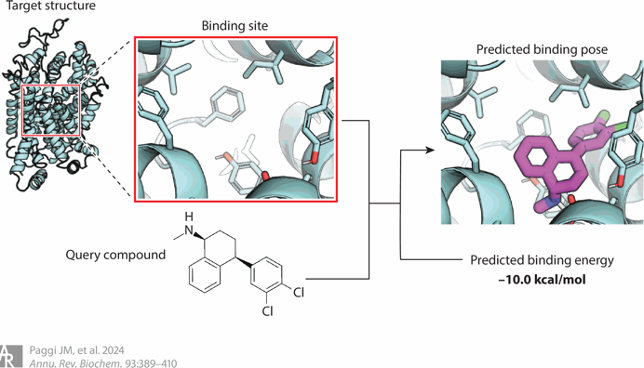

Molecular Docking involves involves two main stages:

1. Sampling: The algorithm explores many possible positions and orientations (or "poses") of the ligand within the receptor's active site. In AutoDock Vina, smina, and gnina, conformations are generated using Monte Carlo Sampling.
2. Scoring: Each generated pose is evaluated using a scoring function which estimates the binding affinity. The scoring function can be empirical, force-field based or even Deep Learning-based.
3. Poses are then ranked on these scores. For Vina scores, lower energy scores indicating more favorable interactions.

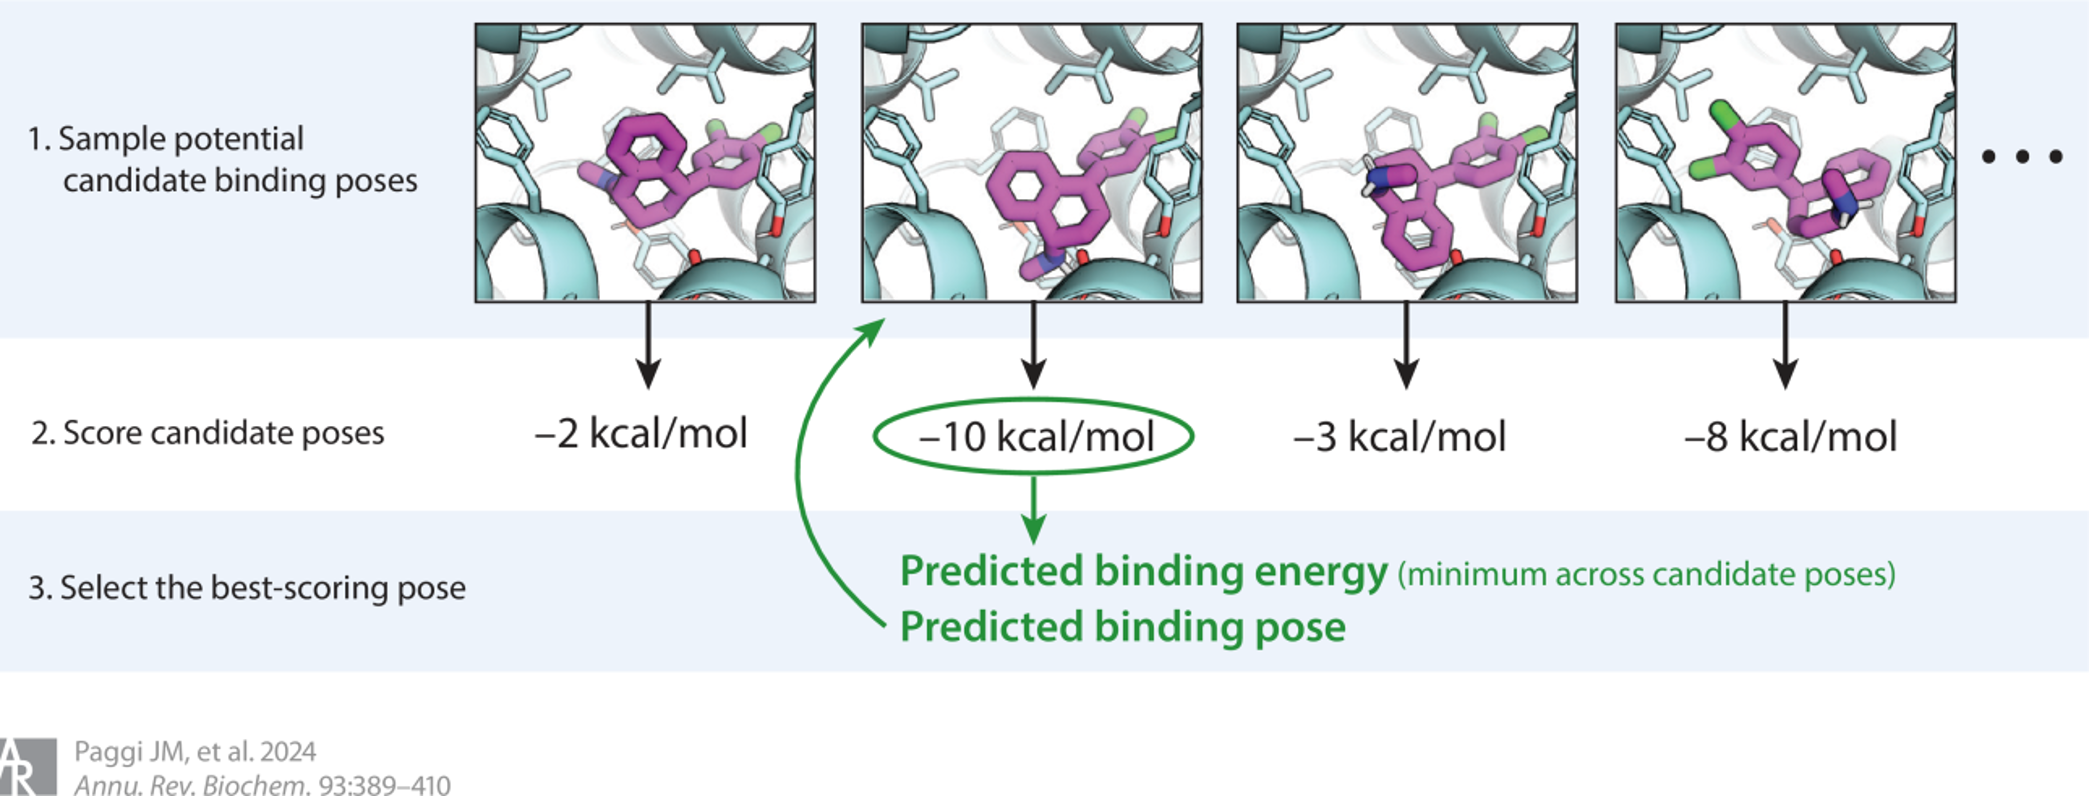

Here are an important point about Molecular Docking: It was developed to be fast so billions of molecules could be screened. That means that crude approximations are often made:

* The protein structure is usually **kept rigid** to simplify the interactions modeled. In reality, proteins are dynamic and can undergo conformational changes upon ligand binding. The ligand flexibility itself is limited!
* The scoring function are simplified at the benefit of speed, meaning they usually hold a good **discriminative** power, not necessarily a good *predictive* power: a good docking score means that the molecule is likely to bind to the protein, it does not means that the binding affinity of this molecule is correlated with the docking score.
* Most docking programs are NOT meant to be used in a blind docking fashion as their sampling procedure is optimized to work with the assumption a binding site will be provided.
* Docking simulations typically focus on binding affinity and pose prediction but often lack the biological context of the protein's environment, such as the presence of co-factors, metal ions, or allosteric regulation, which may influence the ligand binding.

Despite all of these assumptions, molecular docking remains an invaluable tool that is routinely used in drug discovery.

In the rest of this section, we are going to focus on a **re-docking** task, meaning we are going to evaluate how well a docking program's sampling algorithm and scoring function and reproduce a known experimental binding pose.

That means we need to quantitatively evaluate how close the known reference structure. The standard metric used for this comparison is the **Root Mean Square Deviation (RMSD)**. RMSD measures the average distance between corresponding atoms of two molecular structures. A lower RMSD value indicates greater similarity between the docked pose and the reference structure. Mathematically, it's calculated as:

$$
RMSD = ( \frac{1}{N} \sum_{i=1}^{N} \delta_i^2 )^{1/2}
$$


where $N$ is the number of corresponding atom pairs being compared, and $\delta_i$ is the Euclidean distance between the $i$-th pair of atoms.


In docking studies, a common threshold for considering a docked pose "successful" or accurate is an **RMSD below 2 Angstroms** compared to the crystal structure.


## Activity: re-docking a molecule with QVina

To perform a docking calculation, we usually need to prepare a bunch of files. Depending on the quality of the experimental protein structure, this may be more or less tedious: there can be missing residues or atoms, non-standard amino acids, water molecules, incomplete charge information etc.

This is what a typical docking procedure looks like:

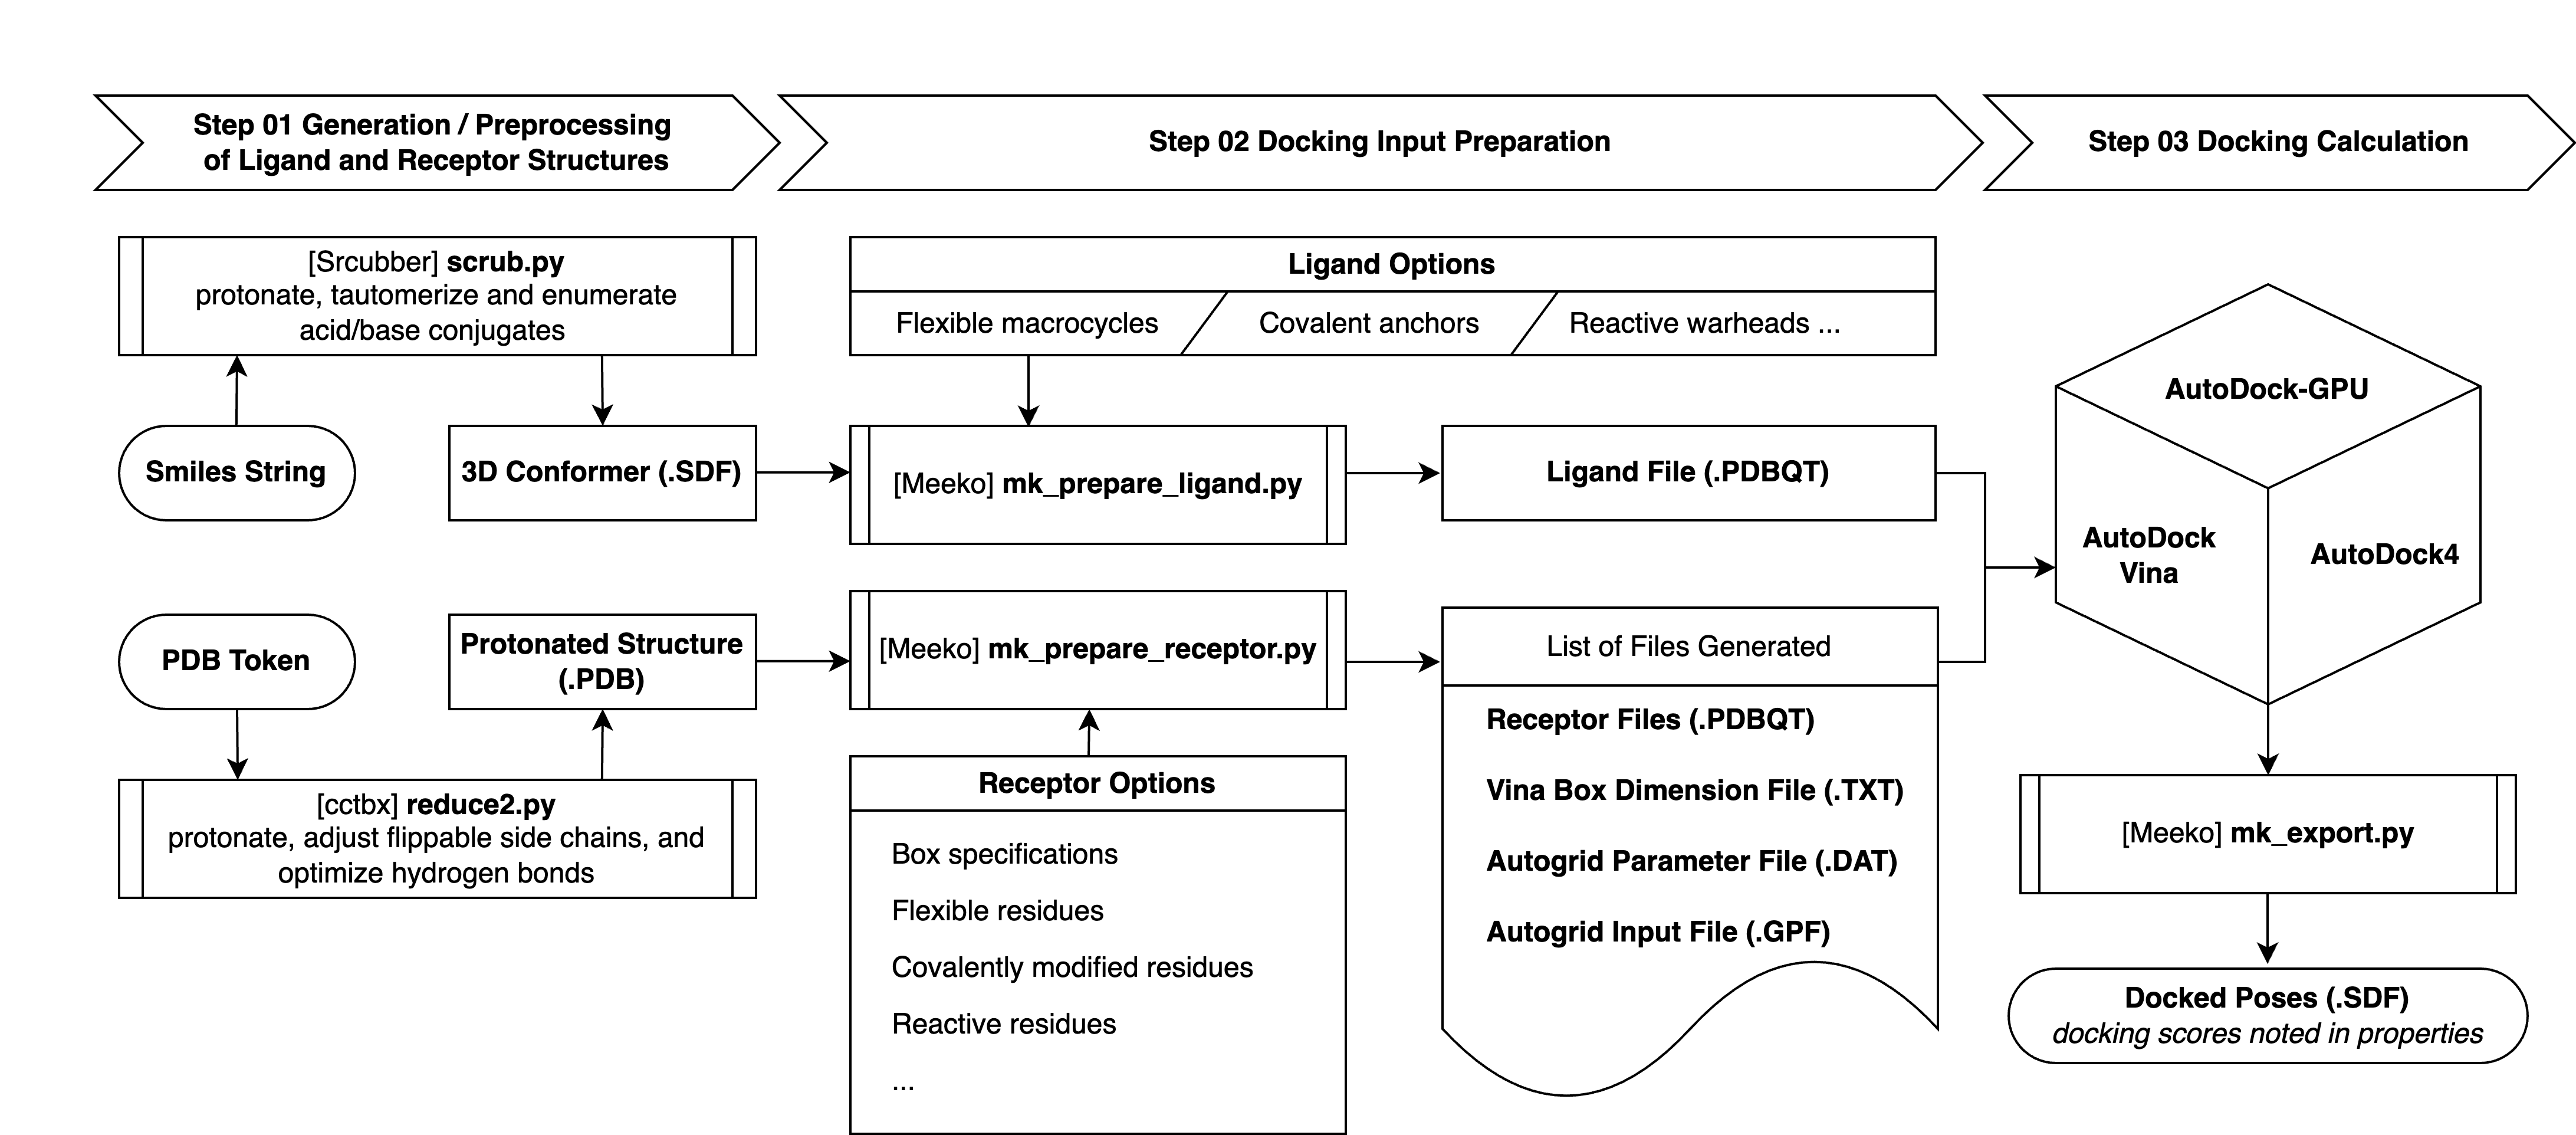

### Logistics

For this lab, we are going to follow a simple docking procedure using Meeko.


### Group 1:

> Ligand:
>
> * Name:
>
> * SMILES:
>
> Protein:
> * PDB ID:

### Group 2:

> Ligand:
>
> * Name:
>
> * SMILES:
>
> Protein:
> * PDB ID:

### Helper functions

In [68]:
# Import modules
import sys, platform
from prody import *
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import AllChem
import rdkit, py3Dmol
print("rdkit version:", rdkit.__version__)
print("py3Dmol version:", py3Dmol.__version__)
from ipywidgets import interact, IntSlider
import ipywidgets, copy
from IPython.display import display, Markdown


# Helper functions
def locate_file(from_path = None, query_path = None, query_name = "query file"):

    if not from_path or not query_path:
        raise ValueError("Must specify from_path and query_path")

    possible_path = list(from_path.glob(query_path))

    if not possible_path:
        raise FileNotFoundError(f"Cannot find {query_name} from {from_path} by {query_path}")

    # return_which = (
    #     f"using {query_name} at:\n"
    #     f"{possible_path[0]}\n"
    # )
    # print(return_which)

    return possible_path[0]


# Commandline scripts
scrub = locate_file(from_path = Path("/usr/local/bin"), query_path = "scrub.py", query_name = "scrub.py")
mk_prepare_ligand = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_ligand.py", query_name = "mk_prepare_ligand.py")
mk_prepare_receptor = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_prepare_receptor.py", query_name = "mk_prepare_receptor.py")
mk_export = locate_file(from_path = Path("/usr/local/bin"), query_path = "mk_export.py", query_name = "mk_export.py")


# Locate reduce2 in conda install prefix
full_py_version = platform.python_version()
major_and_minor = ".".join(full_py_version.split(".")[:2])
env_path = Path("/usr/local") # default conda install prefix on Colab
reduce2_path = f"lib/python{major_and_minor}/site-packages/mmtbx/command_line/reduce2.py"
reduce2 = locate_file(from_path = env_path, query_path = reduce2_path, query_name = "reduce2.py")


# Locate geostd in current path
geostd_path = locate_file(from_path = Path.cwd(), query_path = "geostd", query_name = "geostd")

rdkit version: 2025.03.5
py3Dmol version: 2.5.2


### Step 1: Ligand preparation

In [67]:
# @markdown In this step, the ligand molecule is prepared from a Smiles string. A protonated 3D conformer of ligand is generated by **scrub.py**, and the conversion to a tangible ligand PDBQT file is done by **mk_prepare_ligand.py**.
%%time

# @markdown > Enter the Smiles string of ligand. This will be used as input for ***molscrub*** to protonate and generate a 3D conformer of the ligand.
ligand_Smiles = "CC1=C(NC2=NC=CC(C3=CN=CC=C3)=N2)C=C(NC(C4=CC=C(CN5CCN(C)CC5)C=C4)=O)C=C1" #@param {type:"string"}

# @markdown > Below are some available options of ***molscrub*** to determine what protonation variants to be generated for the input ligand.

# @markdown > A designated pH is required, usually we default to 7
pH = 7 #@param {type:"raw"}
# @markdown > The following two options allow you to opt out from enumeration of tautomers or protomers.
# @markdown > In this the example, we will ask ***molscrub*** to perform acidbase enumeration only for the ligand.
args = ""
skip_tautomer = True #@param {type:"boolean"}
if skip_tautomer:
  args += "--skip_tautomer "
skip_acidbase = False #@param {type:"boolean"}
if skip_acidbase:
  args += "--skip_acidbase "
# @markdown With the above specifications, a 3D conformer of the protonated ligand will be generated by **scrub.py**.
# @markdown
# @markdown The SDF file is then fed to **mk_prepare_ligand.py** to generate the ligand PDBQT file.

# @markdown > A name for the ligand PDBQT file is required.
ligandPDBQT = "STI.pdbqt" #@param {type:"string"}


# Write scrubbed protomer(s) and conformer(s) to SDF
ligandName = ligandPDBQT.replace(".pdbqt", "")
ligandSDF = f"{ligandName}_scrubbed.sdf"
! python {scrub} "{ligand_Smiles}" -o {ligandSDF} --ph {pH} {args}


# Prepare ligand PDBQT
! python {mk_prepare_ligand} -i {ligandSDF} -o {ligandPDBQT}


# Visualization with py3Dmol
view = py3Dmol.view()
view.addModel(open(ligandSDF, 'r').read(),'sdf')
view.zoomTo()
view.setBackgroundColor('white')
view.addStyle({'stick': {'colorscheme':'yellowCarbon'}})
view.show()

Scrub completed.
Summary of what happened:
Input molecules supplied: 1
mols processed: 1, skipped by rdkit: 0, failed: 0
nr isomers (tautomers and acid/base conjugates): 1 (avg. 1.000 per mol)
nr conformers:  1 (avg. 1.000 per isomer, 1.000 per mol)
Traceback (most recent call last):
  File "/usr/local/bin/mk_prepare_ligand.py", line 14, in <module>
    from meeko import MoleculePreparation
  File "/usr/local/lib/python3.12/site-packages/meeko/__init__.py", line 32, in <module>
    from .rdkit_mol_create import RDKitMolCreate
  File "/usr/local/lib/python3.12/site-packages/meeko/rdkit_mol_create.py", line 11, in <module>
    from rdkit.six import StringIO
ModuleNotFoundError: No module named 'rdkit.six'


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

CPU times: user 17.7 ms, sys: 3.15 ms, total: 20.8 ms
Wall time: 2.23 s


### Step 2: Receptor Preparation

In [71]:
%%time
#@markdown The preparation of a rigid receptor consists of two steps. The receptor structure is first sourced from a PDB file and sent to **reduce2.py** for hydrogen addition and optimization, and then, the conversion to a tangible receptor PDBQT file is done by **mk_prepare_receptor.py**.

#@markdown ## (1) Add Hydrogens to Receptor with Reduce2

# @markdown > Enter the PDB ID here to source the starting structure of receptor. This PDB file will be pulled from RCSB PDB server.
# Download PDB file
pdb_token = "1iep" #@param {type:"string"}
! curl "http://files.rcsb.org/view/{pdb_token}.pdb" -o "{pdb_token}.pdb"


# Export receptor atoms
atoms_from_pdb = parsePDB(pdb_token)
# @markdown > Use ProDy selection language to specify atoms to retain in receptor.
receptor_selection = "chain A and not water and not hetero" #@param {type:"string"}
receptor_atoms = atoms_from_pdb.select(receptor_selection)
prody_receptorPDB = f"{pdb_token}_receptor_atoms.pdb"
writePDB(prody_receptorPDB, receptor_atoms)


# Add CRYST1 card (temporarily required for reduce2)
reduce_inputPDB = f"{pdb_token}_receptor.pdb"
! cat <(grep "CRYST1" "{pdb_token}.pdb") {prody_receptorPDB} > {reduce_inputPDB}


# Run reduce2
# @markdown > Use PHIL arguments to specify the tasks for reduce2. In this example, we use `approach=add add_flip_movers=True` which is equivalent to `-build` or `-flip` in the formerly standalone reduce. These arguments ask ***reduce*** to allow NQH flips and build histidines to neutral tautomers while adding hydrogens.
reduce_opts = "approach=add add_flip_movers=True" #@param {type:"string"}
import os
os.environ["MMTBX_CCP4_MONOMER_LIB"] = str(geostd_path)
!echo $MMTBX_CCP4_MONOMER_LIB
!python {reduce2} {reduce_inputPDB} {reduce_opts}

print(reduce2)
print(reduce_inputPDB)
print(reduce_opts)
# Default name of reduce output...
prepare_inPDB = f"{pdb_token}_receptorFH.pdb"

#@markdown ---
#@markdown ## (2) Receptor Preparation with Meeko

# Specify Box
# Center at ligand
atoms_from_pdb = parsePDB(pdb_token)
#@markdown > Use ProDy selection language to specify (ligand, residue, or any) atoms for box center calculation. In this example, we choose the ligand and will use the geometric center of ligand as box center.
ligand_selection = "chain A and resname STI" #@param {type:"string"}
ligand_atoms = atoms_from_pdb.select(ligand_selection)
center_x, center_y, center_z = calcCenter(ligand_atoms)


#@markdown > Export ligand's original position to a PDB file. This is totally optional, but we will do it for visualization.
prody_ligandPDB = "LIG.pdb" #@param {type:"string"}
writePDB(prody_ligandPDB, ligand_atoms)


# Size in each dimension
#@markdown > Enter the box size (Å) of box in each dimension
size_x = 20.0 #@param {type:"raw"}
size_y = 20.0 #@param {type:"raw"}
size_z = 20.0 #@param {type:"raw"}


# @markdown With the above specifications, atom selection will be made on the original PDB file in ***ProDy***. Then, a protonated structure is generated by **reduce2.py**.
# @markdown
# @markdown The PDB file is then fed to **mk_prepare_receptor.py** to generate the receptor PDBQT file.

# Prepare Receptor
# @markdown > A basename for the receptor PDBQT file is required.
prepare_output = "1iep_receptorFH" #@param {type:"string"}
! python {mk_prepare_receptor} -i {prepare_inPDB} -o {prepare_output} -p -v --box_center {center_x} {center_y} {center_z} --box_size {size_x} {size_y} {size_z}


# Visualization with py3Dmol
def Receptor3DView(receptorPDB = None, boxPDB = None, ligPDB = None):

    view = py3Dmol.view()
    view.setBackgroundColor('white')

    view.addModel(open(boxPDB, 'r').read(),'pdb')
    view.addStyle({'stick': {}})
    view.zoomTo()

    view.addModel(open(receptorPDB, 'r').read(),'pdb')
    view.addStyle({'cartoon': {'color':'spectrum', 'opacity': 0.5}})

    if ligPDB is not None:
      view.addModel(open(ligPDB, 'r').read(), 'pdb')
      view.addStyle({'hetflag': True}, {'stick': {}})

    return view

Receptor3DView(receptorPDB = prepare_inPDB, \
               boxPDB = prepare_output+'.box.pdb', \
               ligPDB = prody_ligandPDB).show()

curl: /usr/local/lib/libcurl.so.4: no version information available (required by curl)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  424k    0  424k    0     0   884k      0 --:--:-- --:--:-- --:--:--  885k


@> PDB file is found in working directory (1iep.pdb).
@> 4710 atoms and 1 coordinate set(s) were parsed in 0.08s.


/content/geostd
Starting /usr/local/lib/python3.12/site-packages/mmtbx/command_line/reduce2.py
on Mon Aug 25 02:05:23 2025 by root

Processing files:
-------------------------------------------------------------------------------

  Found model, 1iep_receptor.pdb

Processing PHIL parameters:
-------------------------------------------------------------------------------

  Adding command-line PHIL:
  -------------------------
    approach=add
    add_flip_movers=True

Final processed PHIL parameters:
-------------------------------------------------------------------------------
  data_manager {
    model {
      file = "1iep_receptor.pdb"
    }
    default_model = "1iep_receptor.pdb"
  }
  add_flip_movers = True


Starting job
Writing model output to 1iep_receptorFH.pdb

                       ----------Loading Model----------                       


                      ----------Adding Hydrogens----------                     

Number of hydrogen atoms added to the input model: 218

@> PDB file is found in working directory (1iep.pdb).
@> 4710 atoms and 1 coordinate set(s) were parsed in 0.04s.


/usr/local/lib/python3.12/site-packages/mmtbx/command_line/reduce2.py
1iep_receptor.pdb
approach=add add_flip_movers=True
Traceback (most recent call last):
  File "/usr/local/bin/mk_prepare_receptor.py", line 10, in <module>
    from meeko import PDBQTReceptor
  File "/usr/local/lib/python3.12/site-packages/meeko/__init__.py", line 32, in <module>
    from .rdkit_mol_create import RDKitMolCreate
  File "/usr/local/lib/python3.12/site-packages/meeko/rdkit_mol_create.py", line 11, in <module>
    from rdkit.six import StringIO
ModuleNotFoundError: No module named 'rdkit.six'


FileNotFoundError: [Errno 2] No such file or directory: '1iep_receptorFH.box.pdb'